In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from function import *

In [3]:
df = make_data(dt=0.01, total_time = 50)

In [4]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [5]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [6]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
sc_train_x = scaler.fit_transform(train_x)
sc_test_x = scaler.transform(test_x)

sc_train_y = scaler.fit_transform(train_y.reshape(-1, 1))
sc_test_y = scaler.transform(test_y.reshape(-1, 1))

In [10]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not available")


GPU not available


In [11]:
model = hysterisis_curve(sc_train_x, sc_train_y, sc_test_x, sc_test_y)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [12]:
model.dnn_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 3s 576us/step - loss: 0.1868 - mse: 0.1868
Epoch 2/100
4000/4000 [==============================] - 2s 563us/step - loss: 0.1674 - mse: 0.1674
Epoch 3/100
4000/4000 [==============================] - 2s 553us/step - loss: 0.1654 - mse: 0.1654
Epoch 4/100
4000/4000 [==============================] - 2s 566us/step - loss: 0.1636 - mse: 0.1636
Epoch 5/100
4000/4000 [==============================] - 2s 551us/step - loss: 0.1629 - mse: 0.1629
Epoch 6/100
4000/4000 [==============================] - 2s 562us/step - loss: 0.1621 - mse: 0.1621
Epoch 7/100
4000/4000 [==============================] - 2s 564us/step - loss: 0.1617 - mse: 0.1617
Epoch 8/100
4000/4000 [==============================] - 2s 561us/step - loss: 0.1606 - mse: 0.1606
Epoch 9/100
4000/4000 [==============================] - 2s 564us/step - loss: 0.1613 - mse: 0.1613
Epoch 10/100
4000/4000 [==============================] - 2s 552us/step - loss: 0.1605 - mse: 0.1605

In [13]:
pred = model.dnn_predict()

32/32 [==============================] - 0s 516us/step


In [14]:
real_pred = scaler.inverse_transform(pred)

In [15]:
test_x[:,0]

array([-9.79717439e-15,  6.27905195e-02,  1.25333234e-01, ...,
       -1.25333234e-01, -6.27905195e-02,  1.96438672e-15])

In [16]:
real_pred.reshape(1,-1)[0]

array([-0.00485131,  0.00554334,  0.03967452, ..., -0.05147646,
       -0.02242287, -0.01002306], dtype=float32)

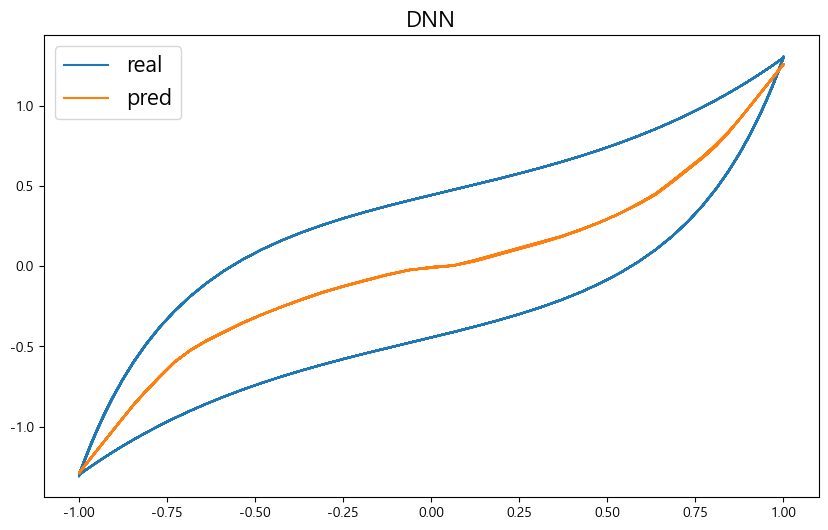

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_pred.reshape(1,-1)[0], label='pred')
plt.title('DNN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

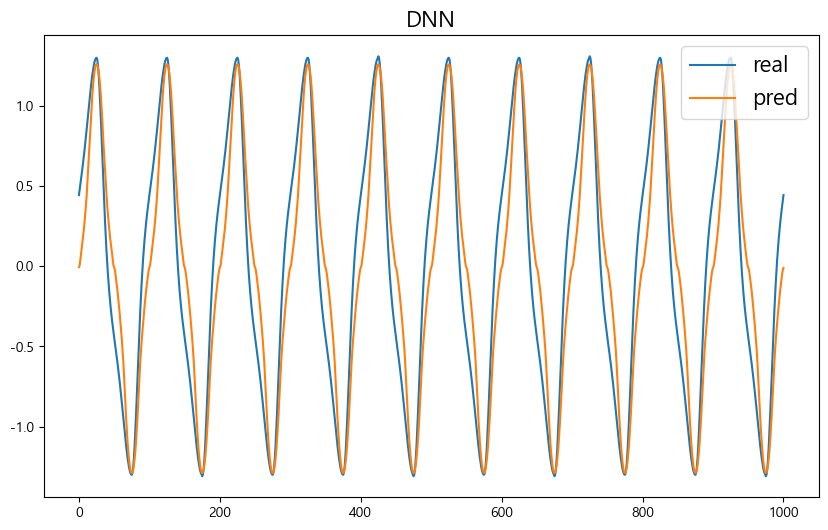

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label = 'real')
plt.plot(real_pred.reshape(1,-1)[0], label = 'pred')
plt.title('DNN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [19]:
lstm_history = model.lstm_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.2039 - mse: 0.2039
Epoch 2/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1700 - mse: 0.1700
Epoch 3/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1672 - mse: 0.1672
Epoch 4/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1657 - mse: 0.1657
Epoch 5/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1654 - mse: 0.1654
Epoch 6/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1631 - mse: 0.1631
Epoch 7/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1643 - mse: 0.1643
Epoch 8/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1635 - mse: 0.1635
Epoch 9/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1629 - mse: 0.1629
Epoch 10/100
4000/4000 [==============================] - 6s 2ms/step - loss: 0.1630 - mse: 0.1630
Epoch 11/100
4000/4

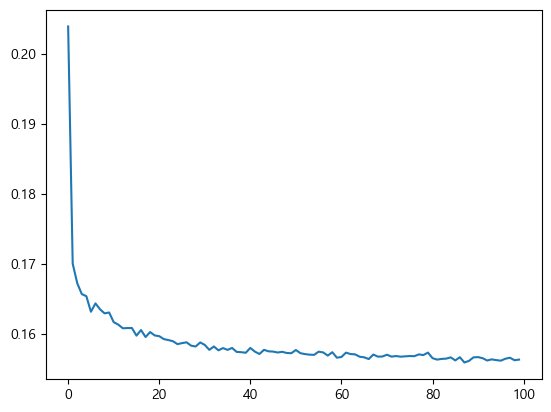

In [20]:
plt.plot(lstm_history.history.history['loss'])

In [21]:
lstm_pred = model.lstm_predict()

32/32 [==============================] - 0s 1ms/step


In [22]:
real_lstm_pred = scaler.inverse_transform(lstm_pred)

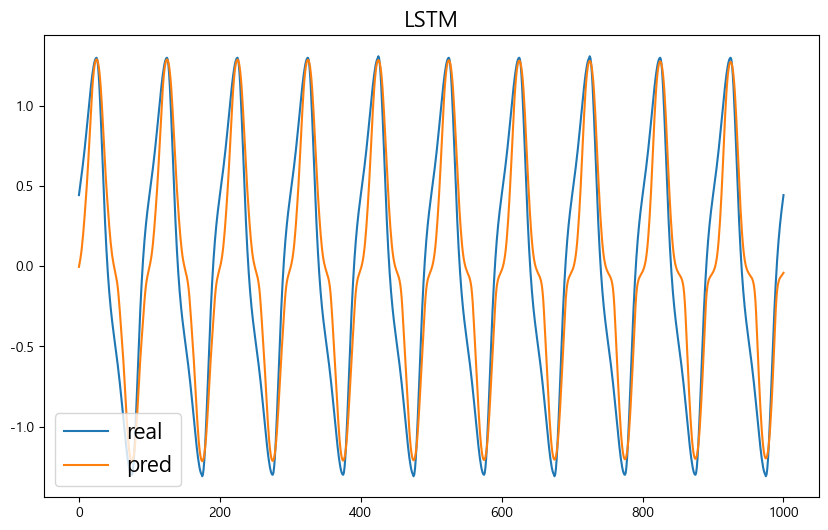

In [23]:
plt.figure(figsize = (10,6))
plt.title('LSTM', fontsize = 16)
plt.plot(test_y, label = 'real')
plt.plot(real_lstm_pred.reshape(1,-1)[0], label = 'pred')
plt.legend(fontsize = 16)
plt.show()

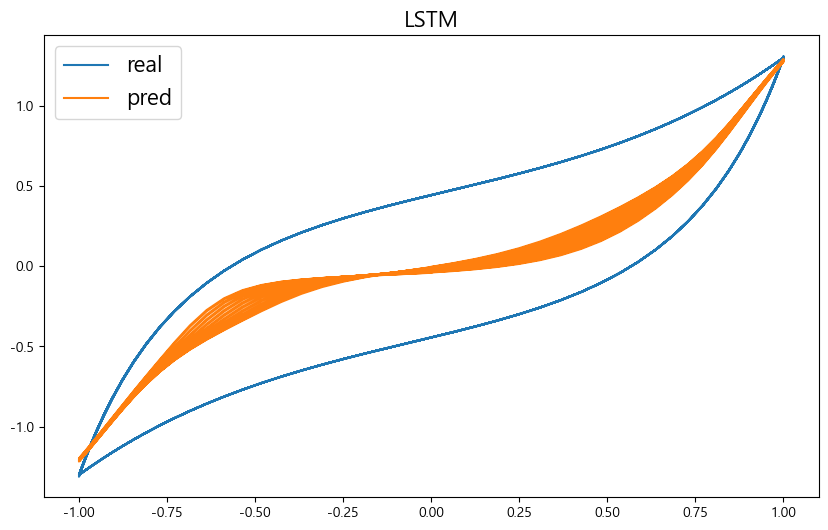

In [24]:
plt.figure(figsize = (10,6))
plt.title('LSTM', fontsize = 16)
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_lstm_pred, label='pred')
plt.legend(fontsize = 16)
plt.show()

In [25]:
import scipy

In [26]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer_z = tf.keras.layers.Dense(units=1)  # To predict z
        self.output_layer_f = tf.keras.layers.Dense(units=output_dim)  # To predict F(t)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        z = self.output_layer_z(x)
        f = self.output_layer_f(x)
        return z, f  # Return both z and F(t)

def compute_boucwen_dynamics(u, z, A, B, G, n):
    # No need to compute gradients here as TensorFlow can automatically compute them during training
    # z = tf.clip_by_value(z, -1e2, 1e2)
    Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n
    return Z_dot

def boucwen_loss(y_true, y_pred_f, u, z_pred, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    Z_dot_pred = compute_boucwen_dynamics(u, z_pred, A, B, G, n)
    
    # Compute physics_loss and data_loss
    physics_loss = tf.reduce_mean(tf.square(Z_dot_pred - z_pred))  # Z_dot_pred should be equal to z_pred according to the Bouc-Wen model
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred_f))  # Predicted F(t) should be close to the true values

    return 0.5 * physics_loss + 0.5 * data_loss  

def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)
        z_pred, y_pred_f = model_pinn_boucwen(x_tr, training=True)
        loss_value = boucwen_loss(y_tr, y_pred_f, u, z_pred, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value


In [36]:
import inspect

In [59]:
import tensorflow as tf

class Modified_PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim, dt=0.01):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer_z = tf.keras.layers.Dense(units=1)  # To predict z
        self.output_layer_f = tf.keras.layers.Dense(units=output_dim)  # To predict F(t)
        self.dt = dt

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        z = self.output_layer_z(x)
        f = self.output_layer_f(x)
        return z, f  # Return both z and F(t)
    
    def compute_boucwen_dynamics(self, u, z, A, B, G, n):
        Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n
        return Z_dot

    def integrate_z(self, Z_dot_pred):
        z_pred = [tf.zeros_like(Z_dot_pred[0])]  # Start with zero initial condition matching the shape of Z_dot_pred elements
        for i in range(1, len(Z_dot_pred)):
            z_next = z_pred[-1] + 0.5 * self.dt * (Z_dot_pred[i-1] + Z_dot_pred[i])
            z_pred.append(z_next)
        return tf.stack(z_pred)

    def boucwen_loss(self, y_true, y_pred_f, u, z_pred, A, B, G, n):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_true = tf.expand_dims(y_true, axis=-1)
        Z_dot_pred = self.compute_boucwen_dynamics(u, z_pred, A, B, G, n)
        z_integrated = self.integrate_z(Z_dot_pred)
        
        physics_loss = tf.reduce_mean(tf.square(z_integrated - y_true))
        data_loss = tf.reduce_mean(tf.square(y_true - y_pred_f))
        return 0.5 * physics_loss + 0.5 * data_loss  

    def train_step_boucwen(self, x_tr, y_tr, A, B, G, n):
        u = x_tr[:, 0]
        u = tf.convert_to_tensor(u)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(u)
            z_pred, y_pred_f = self(x_tr, training=True)
            loss_value = self.boucwen_loss(y_tr, y_pred_f, u, z_pred, A, B, G, n)
        gradients = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss_value


In [60]:
model_pinn_boucwen = Modified_PINN_BoucWen(output_dim=1, dt=0.01)

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [62]:
x_tr = tf.convert_to_tensor(train_x)
y_tr = tf.convert_to_tensor(train_y)
x_te = tf.convert_to_tensor(test_x)
y_te = tf.convert_to_tensor(test_y)

In [63]:
x_tr = tf.cast(x_tr, dtype=tf.float32)
y_tr = tf.cast(y_tr, dtype=tf.float32)
x_te = tf.cast(x_te, dtype=tf.float32)
y_te = tf.cast(y_te, dtype=tf.float32)

In [64]:
epochs = 100

In [65]:
A = 3  
B = 5  
G = 1  
n = 2000

In [66]:
A = 0.1
B = 0.1
G = 0.1
n = 5

In [69]:
from tqdm import tqdm

In [70]:
loss_record = []
for epoch in tqdm(range(epochs)):
    loss = model_pinn_boucwen.train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")
    loss_record.append(loss.numpy())

  1%|          | 1/100 [01:57<3:13:55, 117.53s/it]

Epoch 1, Loss: 228558.359375


  2%|▏         | 2/100 [03:32<2:50:12, 104.21s/it]

Epoch 2, Loss: 2.6057839393615723


  3%|▎         | 3/100 [05:07<2:41:30, 99.91s/it] 

Epoch 3, Loss: 2.3137245178222656


  4%|▍         | 4/100 [06:40<2:35:22, 97.11s/it]

Epoch 4, Loss: 214.47801208496094


  5%|▌         | 5/100 [08:12<2:31:09, 95.47s/it]

Epoch 5, Loss: 5551.05322265625


  6%|▌         | 6/100 [09:45<2:27:58, 94.45s/it]

Epoch 6, Loss: 40338.73046875


  7%|▋         | 7/100 [11:17<2:25:09, 93.65s/it]

Epoch 7, Loss: 78928.7734375


  8%|▊         | 8/100 [12:48<2:22:31, 92.95s/it]

Epoch 8, Loss: 44119.67578125


  9%|▉         | 9/100 [14:20<2:20:32, 92.67s/it]

Epoch 9, Loss: 15829.85546875


 10%|█         | 10/100 [15:53<2:19:00, 92.67s/it]

Epoch 10, Loss: 4252.80224609375


 11%|█         | 11/100 [17:25<2:17:08, 92.46s/it]

Epoch 11, Loss: 971.30712890625


 12%|█▏        | 12/100 [18:57<2:15:38, 92.48s/it]

Epoch 12, Loss: 193.04598999023438


 13%|█▎        | 13/100 [20:29<2:13:35, 92.13s/it]

Epoch 13, Loss: 33.09279251098633


 14%|█▍        | 14/100 [22:00<2:11:32, 91.77s/it]

Epoch 14, Loss: 4.77018928527832


 15%|█▌        | 15/100 [23:30<2:09:39, 91.52s/it]

Epoch 15, Loss: 1.5913505554199219


 16%|█▌        | 16/100 [25:01<2:07:54, 91.36s/it]

Epoch 16, Loss: 1.8602596521377563


 17%|█▋        | 17/100 [26:33<2:06:22, 91.35s/it]

Epoch 17, Loss: 1.982616662979126


 18%|█▊        | 18/100 [28:04<2:04:41, 91.24s/it]

Epoch 18, Loss: 2.0049500465393066


 19%|█▉        | 19/100 [29:35<2:03:01, 91.13s/it]

Epoch 19, Loss: 2.0047664642333984


 20%|██        | 20/100 [31:06<2:01:31, 91.14s/it]

Epoch 20, Loss: 2.0055055618286133


 21%|██        | 21/100 [32:37<1:59:53, 91.06s/it]

Epoch 21, Loss: 1.9956138134002686


 22%|██▏       | 22/100 [34:08<1:58:17, 91.00s/it]

Epoch 22, Loss: 1.9581904411315918


 23%|██▎       | 23/100 [35:38<1:56:43, 90.96s/it]

Epoch 23, Loss: 1.8621569871902466


 24%|██▍       | 24/100 [37:10<1:55:17, 91.01s/it]

Epoch 24, Loss: 1.6894422769546509


 25%|██▌       | 25/100 [38:40<1:53:45, 91.00s/it]

Epoch 25, Loss: 1.5833014249801636


 26%|██▌       | 26/100 [40:11<1:52:10, 90.96s/it]

Epoch 26, Loss: 2.0767648220062256


 27%|██▋       | 27/100 [41:42<1:50:37, 90.93s/it]

Epoch 27, Loss: 2.3851511478424072


 28%|██▊       | 28/100 [43:13<1:49:13, 91.02s/it]

Epoch 28, Loss: 2.2723116874694824


 29%|██▉       | 29/100 [44:44<1:47:40, 90.99s/it]

Epoch 29, Loss: 1.985097885131836


 30%|███       | 30/100 [46:15<1:46:06, 90.95s/it]

Epoch 30, Loss: 1.7588242292404175


 31%|███       | 31/100 [47:46<1:44:40, 91.02s/it]

Epoch 31, Loss: 1.614567518234253


 32%|███▏      | 32/100 [49:17<1:43:07, 91.00s/it]

Epoch 32, Loss: 1.597459316253662


 33%|███▎      | 33/100 [50:48<1:41:34, 90.97s/it]

Epoch 33, Loss: 1.6080098152160645


 34%|███▍      | 34/100 [52:19<1:40:03, 90.96s/it]

Epoch 34, Loss: 1.6154762506484985


 35%|███▌      | 35/100 [53:50<1:38:36, 91.02s/it]

Epoch 35, Loss: 1.6175068616867065


 36%|███▌      | 36/100 [55:21<1:37:03, 90.99s/it]

Epoch 36, Loss: 1.6139013767242432


 37%|███▋      | 37/100 [56:52<1:35:31, 90.97s/it]

Epoch 37, Loss: 1.6058549880981445


 38%|███▊      | 38/100 [58:23<1:34:04, 91.04s/it]

Epoch 38, Loss: 1.5978648662567139


 39%|███▉      | 39/100 [59:54<1:32:31, 91.01s/it]

Epoch 39, Loss: 1.5929949283599854


 40%|████      | 40/100 [1:01:25<1:30:58, 90.98s/it]

Epoch 40, Loss: 1.5920610427856445


 41%|████      | 41/100 [1:02:56<1:29:28, 90.99s/it]

Epoch 41, Loss: 1.590240240097046


 42%|████▏     | 42/100 [1:04:27<1:28:00, 91.05s/it]

Epoch 42, Loss: 1.5844193696975708


 43%|████▎     | 43/100 [1:05:58<1:26:26, 91.00s/it]

Epoch 43, Loss: 1.5746278762817383


 44%|████▍     | 44/100 [1:07:29<1:24:58, 91.05s/it]

Epoch 44, Loss: 1.5584075450897217


 45%|████▌     | 45/100 [1:09:01<1:23:28, 91.07s/it]

Epoch 45, Loss: 1.5403144359588623


 46%|████▌     | 46/100 [1:10:32<1:22:01, 91.13s/it]

Epoch 46, Loss: 1.5240042209625244


 47%|████▋     | 47/100 [1:12:03<1:20:27, 91.08s/it]

Epoch 47, Loss: 1.5101585388183594


 48%|████▊     | 48/100 [1:13:34<1:18:53, 91.03s/it]

Epoch 48, Loss: 1.4975868463516235


 49%|████▉     | 49/100 [1:15:05<1:17:24, 91.07s/it]

Epoch 49, Loss: 1.4844238758087158


 50%|█████     | 50/100 [1:16:36<1:15:49, 91.00s/it]

Epoch 50, Loss: 1.4695661067962646


 51%|█████     | 51/100 [1:18:07<1:14:16, 90.95s/it]

Epoch 51, Loss: 1.4557710886001587


 52%|█████▏    | 52/100 [1:19:37<1:12:45, 90.94s/it]

Epoch 52, Loss: 1.4447572231292725


 53%|█████▎    | 53/100 [1:21:09<1:11:15, 90.96s/it]

Epoch 53, Loss: 1.4350253343582153


 54%|█████▍    | 54/100 [1:22:39<1:09:41, 90.90s/it]

Epoch 54, Loss: 1.4233125448226929


 55%|█████▌    | 55/100 [1:24:10<1:08:09, 90.88s/it]

Epoch 55, Loss: 1.4110153913497925


 56%|█████▌    | 56/100 [1:25:41<1:06:39, 90.91s/it]

Epoch 56, Loss: 1.399667739868164


 57%|█████▋    | 57/100 [1:27:12<1:05:07, 90.87s/it]

Epoch 57, Loss: 1.3895009756088257


 58%|█████▊    | 58/100 [1:28:43<1:03:36, 90.86s/it]

Epoch 58, Loss: 1.3800837993621826


 59%|█████▉    | 59/100 [1:30:13<1:02:04, 90.83s/it]

Epoch 59, Loss: 1.3687721490859985


 60%|██████    | 60/100 [1:31:45<1:00:37, 90.94s/it]

Epoch 60, Loss: 1.3567708730697632


 61%|██████    | 61/100 [1:33:15<59:04, 90.90s/it]  

Epoch 61, Loss: 1.3518282175064087


 62%|██████▏   | 62/100 [1:34:46<57:33, 90.89s/it]

Epoch 62, Loss: 1.3404794931411743


 63%|██████▎   | 63/100 [1:36:17<56:04, 90.93s/it]

Epoch 63, Loss: 1.3441243171691895


 64%|██████▍   | 64/100 [1:37:48<54:33, 90.93s/it]

Epoch 64, Loss: 1.332427978515625


 65%|██████▌   | 65/100 [1:39:19<53:04, 90.98s/it]

Epoch 65, Loss: 1.334457516670227


 66%|██████▌   | 66/100 [1:40:56<52:33, 92.75s/it]

Epoch 66, Loss: 1.3282320499420166


 67%|██████▋   | 67/100 [1:42:34<51:49, 94.22s/it]

Epoch 67, Loss: 1.3262505531311035


 68%|██████▊   | 68/100 [1:44:11<50:46, 95.19s/it]

Epoch 68, Loss: 1.3290051221847534


 69%|██████▉   | 69/100 [1:45:49<49:33, 95.90s/it]

Epoch 69, Loss: 1.3238563537597656


 70%|███████   | 70/100 [1:47:27<48:12, 96.41s/it]

Epoch 70, Loss: 1.3212581872940063


 71%|███████   | 71/100 [1:49:04<46:45, 96.74s/it]

Epoch 71, Loss: 1.3225125074386597


 72%|███████▏  | 72/100 [1:50:42<45:15, 96.98s/it]

Epoch 72, Loss: 1.313494324684143


 73%|███████▎  | 73/100 [1:52:19<43:41, 97.11s/it]

Epoch 73, Loss: 1.3159140348434448


 74%|███████▍  | 74/100 [1:53:57<42:09, 97.28s/it]

Epoch 74, Loss: 1.309303641319275


 75%|███████▌  | 75/100 [1:55:34<40:33, 97.32s/it]

Epoch 75, Loss: 1.3054144382476807


 76%|███████▌  | 76/100 [1:57:12<38:57, 97.38s/it]

Epoch 76, Loss: 1.305624008178711


 77%|███████▋  | 77/100 [1:58:49<37:22, 97.51s/it]

Epoch 77, Loss: 1.2982486486434937


 78%|███████▊  | 78/100 [2:00:27<35:44, 97.49s/it]

Epoch 78, Loss: 1.2986785173416138


 79%|███████▉  | 79/100 [2:02:04<34:06, 97.45s/it]

Epoch 79, Loss: 1.2934380769729614


 80%|████████  | 80/100 [2:03:42<32:30, 97.50s/it]

Epoch 80, Loss: 1.2888551950454712


 81%|████████  | 81/100 [2:05:20<30:53, 97.57s/it]

Epoch 81, Loss: 1.287149429321289


 82%|████████▏ | 82/100 [2:06:57<29:15, 97.54s/it]

Epoch 82, Loss: 1.2794551849365234


 83%|████████▎ | 83/100 [2:08:35<27:38, 97.54s/it]

Epoch 83, Loss: 1.277038812637329


 84%|████████▍ | 84/100 [2:10:12<26:00, 97.53s/it]

Epoch 84, Loss: 1.2703578472137451


 85%|████████▌ | 85/100 [2:11:50<24:24, 97.62s/it]

Epoch 85, Loss: 1.2664616107940674


 86%|████████▌ | 86/100 [2:13:27<22:45, 97.54s/it]

Epoch 86, Loss: 1.259345531463623


 87%|████████▋ | 87/100 [2:15:05<21:07, 97.53s/it]

Epoch 87, Loss: 1.2519724369049072


 88%|████████▊ | 88/100 [2:16:43<19:31, 97.63s/it]

Epoch 88, Loss: 1.2439533472061157


 89%|████████▉ | 89/100 [2:18:20<17:53, 97.59s/it]

Epoch 89, Loss: 1.2435873746871948


 90%|█████████ | 90/100 [2:19:58<16:15, 97.57s/it]

Epoch 90, Loss: 1.2354929447174072


 91%|█████████ | 91/100 [2:21:35<14:38, 97.56s/it]

Epoch 91, Loss: 1.2173793315887451


 92%|█████████▏| 92/100 [2:23:13<13:00, 97.62s/it]

Epoch 92, Loss: 1.243211030960083


 93%|█████████▎| 93/100 [2:24:51<11:23, 97.68s/it]

Epoch 93, Loss: 1.2123790979385376


 94%|█████████▍| 94/100 [2:26:28<09:45, 97.65s/it]

Epoch 94, Loss: 1.2277332544326782


 95%|█████████▌| 95/100 [2:28:06<08:08, 97.74s/it]

Epoch 95, Loss: 1.1921440362930298


 96%|█████████▌| 96/100 [2:29:44<06:30, 97.74s/it]

Epoch 96, Loss: 1.1854585409164429


 97%|█████████▋| 97/100 [2:31:22<04:53, 97.72s/it]

Epoch 97, Loss: 1.1917307376861572


 98%|█████████▊| 98/100 [2:32:59<03:15, 97.74s/it]

Epoch 98, Loss: 1.1520408391952515


 99%|█████████▉| 99/100 [2:34:33<01:36, 96.52s/it]

Epoch 99, Loss: 1.154632568359375


100%|██████████| 100/100 [2:36:04<00:00, 93.65s/it]

Epoch 100, Loss: 1.1412192583084106


In [73]:
z_pred, y_pred_f = model_pinn_boucwen(x_te)

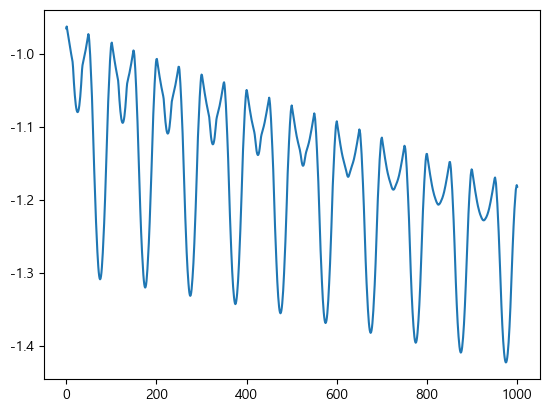

In [75]:
plt.plot(z_pred)

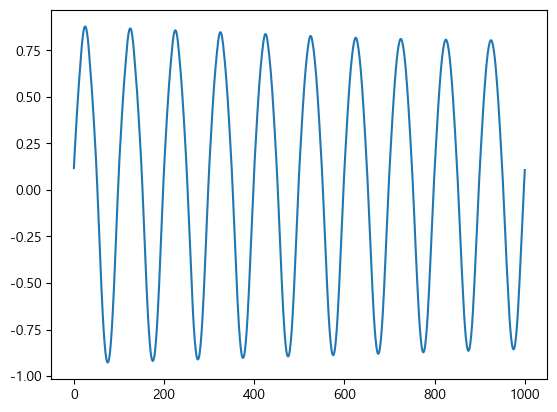

In [76]:
plt.plot(y_pred_f)

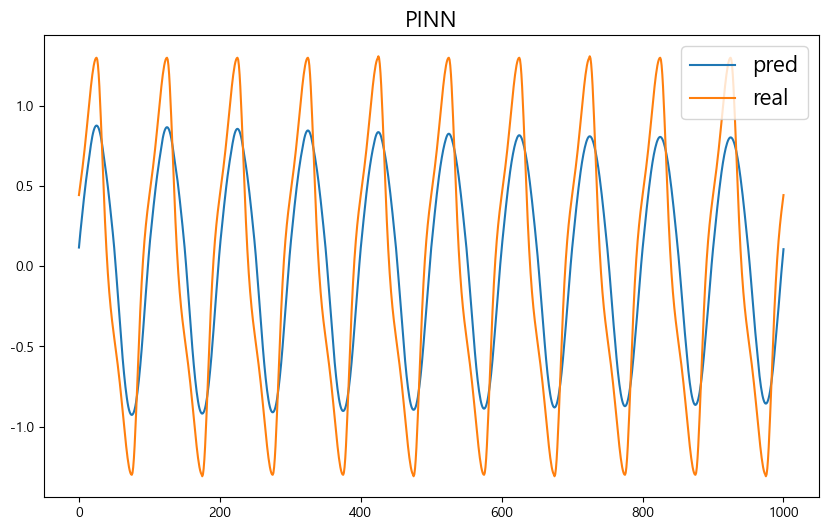

In [77]:
plt.figure(figsize = (10,6))
plt.plot(y_pred_f, label = 'pred')
plt.plot(y_te, label = 'real')
plt.title('PINN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

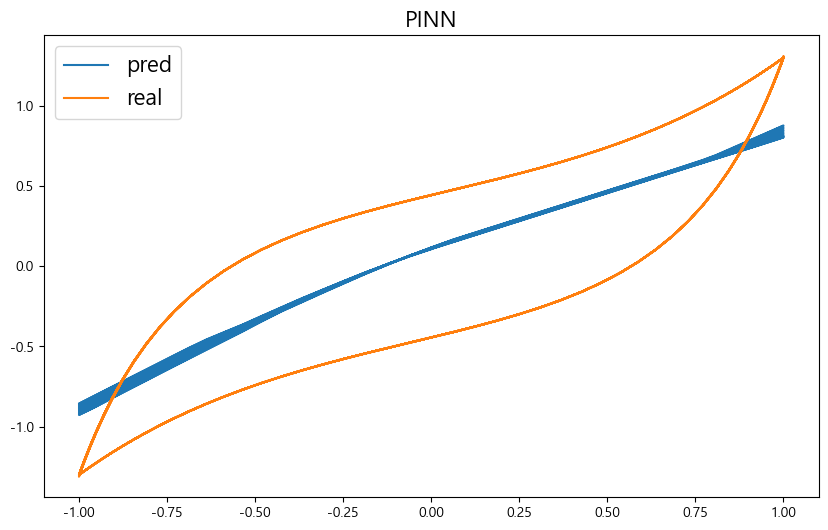

In [79]:
plt.figure(figsize = (10, 6))
plt.plot(test_x[:,0], y_pred_f, label = 'pred')
plt.plot(test_x[:,0], y_te, label = 'real')
plt.legend(fontsize = 16)
plt.title('PINN', fontsize= 16)
plt.show()